In [36]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- System Parameters (Mass = 1.0kg, Power) ---
PARAMS = {
    'm': 1.0,            # Mass = 1.0 kg
    'g': 9.81,
    'Ix': 0.0081,
    'Iy': 0.0081,
    'Iz': 0.0142,
    'P_hover': 220.0,    # Est. Hover Power for 1kg
    'Bat_Cap': 207792.0  # Battery Capacity (Joules)
}


def drone_dyn(t, state, con_in):
    x, y, z, phi, the, psi, dx, dy, dz, p, q, r = state
    T, tau_phi, tau_the, tau_psi = con_in

    phi = np.clip(phi, -1.4, 1.4)
    the = np.clip(the, -1.4, 1.4)

    c_phi = math.cos(phi); s_phi = math.sin(phi)
    c_the = math.cos(the); s_the = math.sin(the)
    c_psi = math.cos(psi); s_psi = math.sin(psi)

    R13 = s_phi*s_psi + c_phi*c_psi*s_the
    R23 = c_phi*s_psi*s_the - c_psi*s_phi
    R33 = c_phi*c_the

    ddx = (T/PARAMS['m']) * R13
    ddy = (T/PARAMS['m']) * R23
    ddz = (T/PARAMS['m']) * R33 - PARAMS['g']

    dp = (tau_phi + (PARAMS['Iy'] - PARAMS['Iz']) * q * r) / PARAMS['Ix']
    dq = (tau_the + (PARAMS['Iz'] - PARAMS['Ix']) * p * r) / PARAMS['Iy']
    dr = (tau_psi + (PARAMS['Ix'] - PARAMS['Iy']) * p * q) / PARAMS['Iz']

    if abs(c_the) < 0.05: c_the = 0.05
    t_the = math.tan(the)
    dphi = p + q * s_phi * t_the + r * c_phi * t_the
    dthe =     q * c_phi           - r * s_phi
    dpsi =    (q * s_phi           + r * c_phi) / c_the

    return np.array([dx, dy, dz, dphi, dthe, dpsi, ddx, ddy, ddz, dp, dq, dr])


class DroneController:
    def __init__(self):
        self.Kp_pos = 2.0; self.Kd_pos = 4.0
        self.Kp_z = 10.0; self.Kd_z = 5.0
        self.Kp_att = 10.0; self.Kd_att = 5.0
        self.Kp_yaw = 2.0; self.Kd_yaw = 1.0

    def get_control(self, t, state, target):
        x, y, z, phi, the, psi, dx, dy, dz, p, q, r = state


        x_d, y_d, z_d, psi_d = target[0], target[1], target[2], target[3]

        # Check for Feedforward terms (vx, vy, ax, ay)
        vx_d, vy_d = 0.0, 0.0
        ax_d, ay_d = 0.0, 0.0
        if len(target) >= 8:
            vx_d, vy_d = target[4], target[5]
            ax_d, ay_d = target[6], target[7]

        # Altitude
        ez = z_d - z; edz = 0 - dz
        u_z = self.Kp_z * ez + self.Kd_z * edz + PARAMS['g']

        c_phi = np.clip(math.cos(phi), 0.1, 1.0)
        c_the = np.clip(math.cos(the), 0.1, 1.0)
        tot_thr = PARAMS['m'] * u_z / (c_phi * c_the)
        tot_thr = np.clip(tot_thr, 0, PARAMS['m']*20)

        # Position Control with Feedforward
        # Error = (Target - Actual)
        ex = x_d - x
        edx = vx_d - dx
        ey = y_d - y
        edy = vy_d - dy

        ax_global = self.Kp_pos * ex + self.Kd_pos * edx + ax_d
        ay_global = self.Kp_pos * ey + self.Kd_pos * edy + ay_d

        # Body Frame Rotation
        c_p = math.cos(psi); s_p = math.sin(psi)
        ax_body =  ax_global * c_p + ay_global * s_p
        ay_body = -ax_global * s_p + ay_global * c_p

        # Desired Angles
        the_des = np.clip( ax_body / PARAMS['g'], -0.5, 0.5)
        phi_des = np.clip(-ay_body / PARAMS['g'], -0.5, 0.5)

        # Attitude
        tau_phi = self.Kp_att * (phi_des - phi) + self.Kd_att * (0 - p)
        tau_the = self.Kp_att * (the_des - the) + self.Kd_att * (0 - q)

        # Yaw
        e_psi = (psi_d - psi + np.pi) % (2 * np.pi) - np.pi
        tau_psi = self.Kp_yaw * e_psi + self.Kd_yaw * (0 - r)

        return tot_thr, tau_phi, tau_the, tau_psi

class BatteryMonitor:
    def __init__(self):
        self.energy_used = 0.0
        self.hover_thrust = PARAMS['m'] * PARAMS['g']
    def update(self, thrust, dt):
        ratio = thrust / self.hover_thrust
        if ratio < 0: ratio = 0
        p_inst = PARAMS['P_hover'] * (ratio ** 1.5)
        self.energy_used += p_inst * dt
        return self.energy_used

def rk4_step(t, dt, state, ctrl):
    state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    k1 = drone_dyn(t,             state,                 ctrl)
    k2 = drone_dyn(t + 0.5*dt,    state + 0.5*dt*k1,     ctrl)
    k3 = drone_dyn(t + 0.5*dt,    state + 0.5*dt*k2,     ctrl)
    k4 = drone_dyn(t + dt,        state + dt*k3,         ctrl)
    return state + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

Goal 1 (Hover 2min) Energy Used: 26400.0 J
Battery Remaining: 87.3%


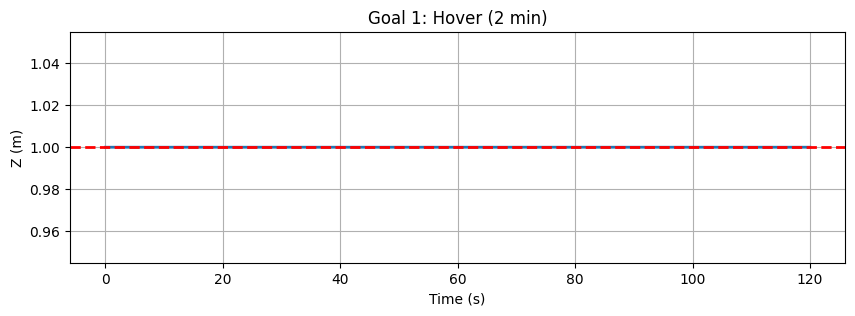

In [37]:
def run_goal1():
    dur = 120.0
    dt_sim = 0.01
    teval = np.arange(0.0, dur + dt_sim, dt_sim)
    steps = len(teval)
    states = np.zeros((steps, 12), dtype=float)
    states[0] = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    cur_st = states[0].copy()

    control = DroneController()
    bat = BatteryMonitor()

    for i in range(steps - 1):
        t = teval[i]
        ctrl = control.get_control(t, cur_st, [0.0, 0.0, 1.0, 0.0])
        cur_st = rk4_step(t, dt_sim, cur_st, ctrl)
        states[i + 1] = cur_st

        # Track Power
        bat.update(ctrl[0], dt_sim)

    # check power status and remaining bat
    print(f"Goal 1 (Hover 2min) Energy Used: {bat.energy_used:.1f} J")
    print(f"Battery Remaining: {(1 - bat.energy_used/PARAMS['Bat_Cap'])*100:.1f}%")

    return teval, states

t1, s1 = run_goal1()

plt.figure(figsize=(10, 3))
plt.plot(t1, s1[:, 2])
plt.axhline(1.0, color='r', linestyle='--')
plt.title('Goal 1: Hover (2 min)'); plt.grid()
plt.xlabel('Time (s)'); plt.ylabel('Z (m)')
plt.show()

Goal 2 Complete.
Energy Used: 14301.3 J / 207792.0 J


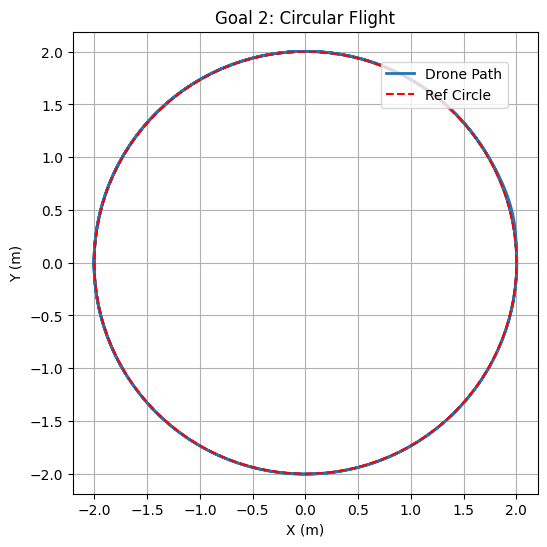

In [43]:
def run_goal2_perfect():
    dur = 65.0
    dt = 0.002
    steps = int(dur/dt)
    teval = np.linspace(0, dur, steps)
    states = np.zeros((steps, 12))

    r = 2.0
    v = 0.5
    omega = v / r

    # Initialize on circle with correct tangent velocity
    # vx = -r*w*sin(0) = 0, vy = r*w*cos(0) = v
    states[0] = [2.0, 0, 1.0, 0,0,0, 0,v,0, 0,0,0]
    cur = states[0].copy()

    ctrl = DroneController()
    bat = BatteryMonitor()

    for i in range(steps-1):
        t = teval[i]

        # 1. Target Position
        theta = omega * t
        xt = r * math.cos(theta)
        yt = r * math.sin(theta)

        # 2. Target Velocity (Feedforward)
        vxt = -r * omega * math.sin(theta)
        vyt =  r * omega * math.cos(theta)

        # 3. Target Acceleration (Feedforward Centripetal Force)

        axt = -r * (omega**2) * math.cos(theta)
        ayt = -r * (omega**2) * math.sin(theta)

        # 4. Heading
        psi_t = theta + (np.pi/2)

        # Extended Target Vector [x, y, z, psi, vx, vy, ax, ay]
        target_vec = [xt, yt, 1.0, psi_t, vxt, vyt, axt, ayt]

        T_cmd, tp, tt, tps = ctrl.get_control(t, cur, target_vec)
        cur = rk4_step(t, dt, cur, [T_cmd, tp, tt, tps])
        states[i+1] = cur

        bat.update(T_cmd, dt)

    return teval, states, bat

# Run and Plot
t2, s2, bat2 = run_goal2_perfect()

print(f"Goal 2 Complete.")
print(f"Energy Used: {bat2.energy_used:.1f} J / {PARAMS['Bat_Cap']:.1f} J")

plt.figure(figsize=(6,6))
plt.plot(s2[:,0], s2[:,1], label='Drone Path', linewidth=2)

ref = np.linspace(0, 2*np.pi, 100)
plt.plot(2*np.cos(ref), 2*np.sin(ref), 'r--', label='Ref Circle', linewidth=1.5)

plt.title('Goal 2: Circular Flight')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')
plt.grid(True)
plt.axis('equal')

plt.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95))

plt.show()


Goal 3 (L-Maneuver) Energy Used: 28602.2 J
Battery Remaining: 86.2%


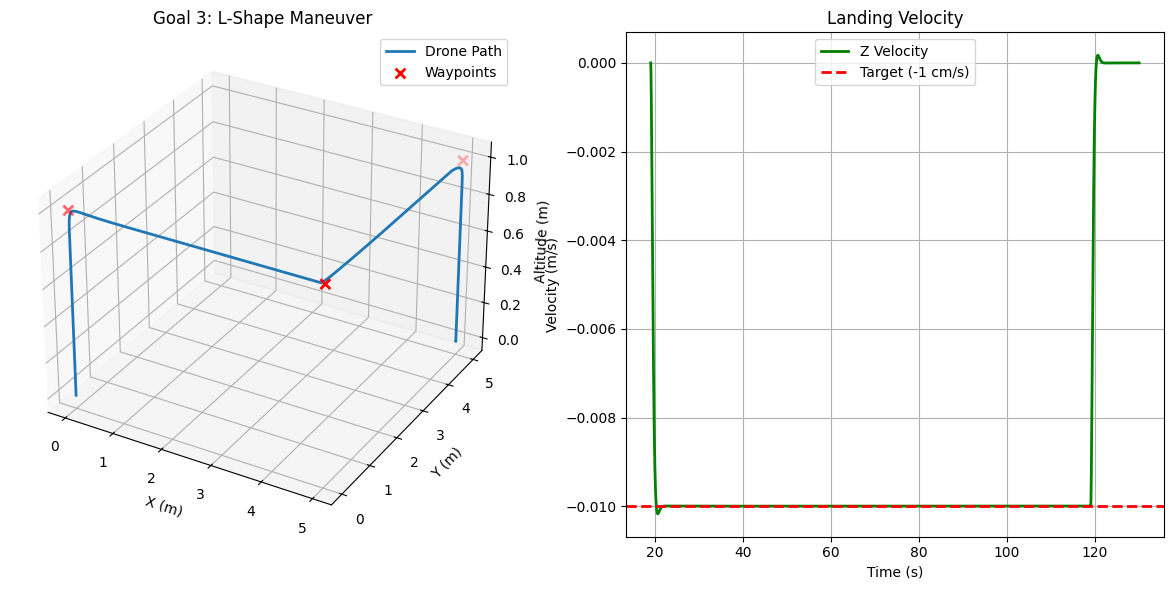

In [39]:
def run_goal_3():
    control = DroneController()
    bat = BatteryMonitor()

    def get_target(t):
        psi_fixed = 0.0
        if t < 2.0:
            z = np.interp(t, [0, 2], [0, 1])
            return [0, 0, z, psi_fixed]
        elif t < 7.0:
            x = np.interp(t, [2, 7], [0, 5])
            return [x, 0, 1, psi_fixed]
        elif t < 9.0:
            return [5, 0, 1, psi_fixed]
        elif t < 12.0:
            return [5, 0, 1, psi_fixed]
        elif t < 17.0:
            y = np.interp(t, [12, 17], [0, 5])
            return [5, y, 1, psi_fixed]
        elif t < 19.0:
            return [5, 5, 1, psi_fixed]
        else:
            land = t - 19.0
            z = 1.0 - (land * 0.01)
            if z < 0: z = 0
            return [5, 5, z, psi_fixed]

    dt = 0.002
    dur = 130.0
    steps = int(dur / dt)

    teval = np.linspace(0, dur, steps)
    shis = np.zeros((steps, 12))
    cur = np.zeros(12)
    shis[0] = cur

    for i in range(steps-1):
        t = teval[i]
        tgt = get_target(t)

        try:
            ctrl = control.get_control(t, cur, tgt)
            cur = rk4_step(t, dt, cur, ctrl)

            # Track Power
            bat.update(ctrl[0], dt)

        except ValueError:
            print(f"Crash prevented at t={t:.2f}")
            break

        shis[i+1] = cur

    # check power status and remaining bat
    print(f"Goal 3 (L-Maneuver) Energy Used: {bat.energy_used:.1f} J")
    print(f"Battery Remaining: {(1 - bat.energy_used/PARAMS['Bat_Cap'])*100:.1f}%")

    return teval, shis

t3, s3 = run_goal_3()

# Plots
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(s3[:, 0], s3[:, 1], s3[:, 2], linewidth=2, label='Drone Path')
ax.scatter([0, 5, 5], [0, 0, 5], [1, 1, 1], c='r', marker='x', s=50, label='Waypoints')
ax.set_title('Goal 3: L-Shape Maneuver')
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Altitude (m)')
ax.legend()

ax2 = fig.add_subplot(1, 2, 2)
land_m = t3 > 19.0
if np.any(land_m):
    ax2.plot(t3[land_m], s3[land_m, 8], 'g', label='Z Velocity')
    ax2.axhline(-0.01, color='r', linestyle='--', label='Target (-1 cm/s)')
    ax2.set_title('Landing Velocity')
    ax2.set_ylabel('Velocity (m/s)'); ax2.set_xlabel('Time (s)')
    ax2.grid(True); ax2.legend()

plt.tight_layout(); plt.show()